# Analysis of Public Interest on Initial Public Offering (IPO) on Bursa Malaysia (Using a Synthetic Dataset).

<b>This exercise is for entertainment purpose only. Do not trade shares based on this exercise. Trading shares involve capital loss and emotional pain. Please consult your investment advisor before embarking on any financial exercise.</b>

Based on my initial observation, I saw different behavior for shares that were listed either below RM1 (<RM1) or at least RM1 (>=RM).
Thus for the analyses below at the RM1 cutoff.

This analysis is done on a synthetic dataset, generated from a real dataset of IPOs from 2017 till 14th May 2023.

In [1]:
import pandas as pd
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("IPO_2017to2022_synthetic.csv")

# drop those with TOTALBALLOTINGOSCBED NaN
df = df[df['TOTALBALLOTINGOSCBED'].notna()]

### Feature Engineering and Data Clean-Up

Create following columns:
- % difference between list price vs opening price on IPO day
- % difference between list price vs highest price on IPO day
- % difference between opening price on IPO day vs closing price on IPO day
- % difference between opening price on IPO day vs highest price on IPO day

In [3]:
df['LISTVSOPENING_PCT'] = df['OPENPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSHIGHEST_PCT'] = df['HIGHESTPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSCLOSING_PCT'] = df['CLOSINGPRICEIPODAY']/df['LISTPRICE']*100 - 100

In [4]:
df.shape

(198, 15)

In [5]:
# grab all available years
years = sorted(df['YEAR'].unique().tolist()[::-1])
years

[2017, 2018, 2019, 2020, 2021, 2022]

## Measuring Subscription Interest: Oversubscription Rate by Year

I first ask this question: how does public interest towards IPOs change over the years? I am interested in this question since I have encountered anecdotes from acquaintances and friends that it is getting harder to get any units from IPO offering since 2020.

In [6]:
# function to calculate bar height, bar error bars and counts, after dividing by RM<1 and RM>=1

def calculate_bardata(years, df, targetvar):

    barheight = {}
    barheight['lt1'] = {}
    barheight['mt1'] = {}

    barerr = {}
    barerr['lt1'] = {}
    barerr['mt1'] = {}

    count = {}
    count['lt1']={}
    count['mt1']={}

    for year in years:
        # for < RM1
        df_series_lt1 = df[((df['YEAR']==year)  & (df['LISTPRICE']<1))][targetvar]

        count['lt1'][year] = df_series_lt1.count()
        mean_year_lt1 = round(df_series_lt1.mean(),2)

        barheight['lt1'][year] = mean_year_lt1
        if df_series_lt1.count() >1:
            barerr['lt1'][year] = round(stdev(df_series_lt1),2)
        else:
            barerr['lt1'][year] = 0

        # for >= RM1
        df_series_mt1 = df[((df['YEAR']==year)  & (df['LISTPRICE']>=1))][targetvar]

        count['mt1'][year] = df_series_mt1.count()
        mean_year_mt1 = round(df_series_mt1.mean(),2)

        barheight['mt1'][year] = mean_year_mt1
        if df_series_mt1.count() >1:
            barerr['mt1'][year] = round(stdev(df_series_mt1),2)
        else:
            barerr['mt1'][year] = 0
            
    return count, barheight, barerr

In [7]:
count, barheight, barerr = calculate_bardata(years, df, 'TOTALBALLOTINGOSCBED')

print("For listing price < RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price >= RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))


For listing price < RM1:
2017(15): mean 38.97, stdev 26.22
2018(32): mean 18.27, stdev 19.44
2019(27): mean 20.6, stdev 18.47
2020(14): mean 36.62, stdev 28.0
2021(40): mean 66.29, stdev 48.89
2022(44): mean 53.82, stdev 42.87

For listing price >= RM1:
2017(9): mean 4.61, stdev 2.02
2018(2): mean 7.23, stdev 3.45
2019(3): mean 4.23, stdev 0.73
2020(3): mean 3.76, stdev 0.24
2021(7): mean 26.34, stdev 14.82
2022(2): mean 23.65, stdev 6.17


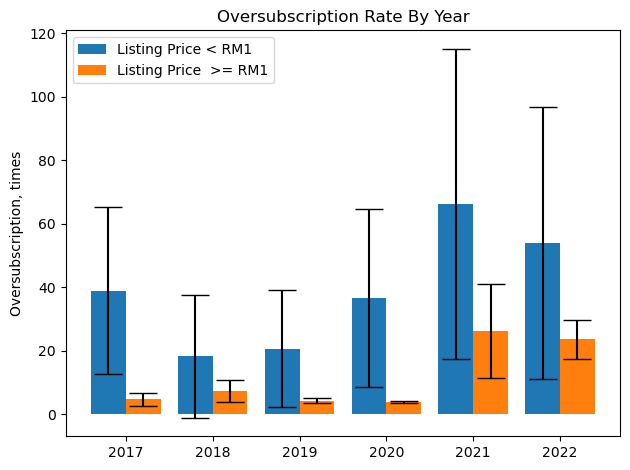

In [8]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Oversubscription, times')
plt.title('Oversubscription Rate By Year')
plt.legend(["Listing Price < RM1", "Listing Price  >= RM1"])

plt.tight_layout()
plt.show()

Here you see from 2017 till 2019, oversubscription for IPOs goes down. Interestingly, things changed dramatically since then, where it more than doubled from 2019 to 2020, and again in 2020 to 2021 (for price less than RM1).

Also note that oversubcription is much lower in general for IPOs with listing price more than RM1.

The huge increase in ovesubscription rate starting in 2020 is consistent with the heightened interest from the public in the stock market as stay-at-home orders were issued due to Covid: we did not only see higher trading volume on the open market in general, as have been covered by other reports, we also see higher subscription to the IPOs offered.

Also, it looks like interest for IPOs so far in 2022 has waned when compared to 2021.

## Measuring Speculative Activity on IPO Day: Volume on IPO day by Year
I now ask the question, if there is an increase in public interest from 2019 to 2021 as measured by the oversubscription rate, does this translate into higher trading volume on the counter on IPO day?

One scenario that I could imagine is that, could it be that other people who did not get the IPO, also participate on the counter on IPO day (although this can't be proven directly unless we track the trading tickets that day and compare their executers vs list of IPO awardees)?

In [9]:
count, barheight, barerr = calculate_bardata(years, df, 'VOLUMEIPODAY')
print("For listing price < RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price >= RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))


For listing price < RM1:
2017(15): mean 1112344.87, stdev 860204.29
2018(32): mean 1063492.53, stdev 645404.45
2019(27): mean 1377868.59, stdev 1074746.06
2020(14): mean 1834378.71, stdev 691377.81
2021(40): mean 1733618.7, stdev 707920.02
2022(44): mean 1541406.34, stdev 622568.21

For listing price >= RM1:
2017(9): mean 409888.67, stdev 267199.38
2018(2): mean 735926.0, stdev 2322.14
2019(3): mean 1440202.33, stdev 1632618.21
2020(3): mean 1205676.0, stdev 642769.01
2021(7): mean 1875159.71, stdev 908961.94
2022(2): mean 4084125.5, stdev 155243.17


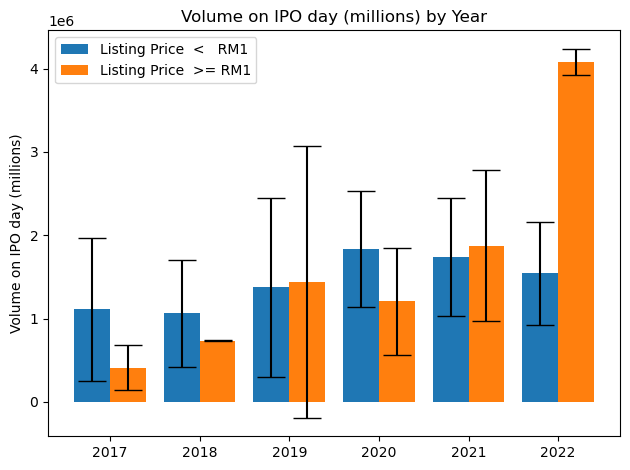

In [10]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Volume on IPO day (millions)')
plt.title('Volume on IPO day (millions) by Year')
plt.legend(["Listing Price  <   RM1", "Listing Price  >= RM1"])

plt.tight_layout()
plt.show()

Interestingly, 2020 is the year with highest volume on IPOed counter on IPO day, even though 2021 is the year with the highest oversubscription rates. In 2021 and 2022, the volume on IPOed counter decreased a bit vis-a-vis 2020.

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Opening Price

Now we see a higher volume on average on the IPOed counter on IPO day in 2020 (and also 2021), does this translate into more price movement on that day? Specifically I am interested in seeing the percentage difference between:

1. listing price versus opening price (first matched ticket at 9AM)
2. listing price versus highest price at any time during IPO day.

Let's look at (1) first.

In [11]:
count, barheight, barerr = calculate_bardata(years, df, 'LISTVSOPENING_PCT')
print("For listing price < RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price >= RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))

For listing price < RM1:
2017(15): mean 21.47, stdev 33.6
2018(32): mean 32.45, stdev 45.46
2019(27): mean 37.25, stdev 64.92
2020(14): mean 71.62, stdev 70.06
2021(40): mean 50.76, stdev 56.35
2022(44): mean 31.1, stdev 48.28

For listing price >= RM1:
2017(9): mean -30.18, stdev 44.51
2018(2): mean 3.65, stdev 0.59
2019(3): mean 16.27, stdev 28.03
2020(3): mean 13.43, stdev 32.43
2021(7): mean -6.73, stdev 25.64
2022(2): mean 3.87, stdev 6.4


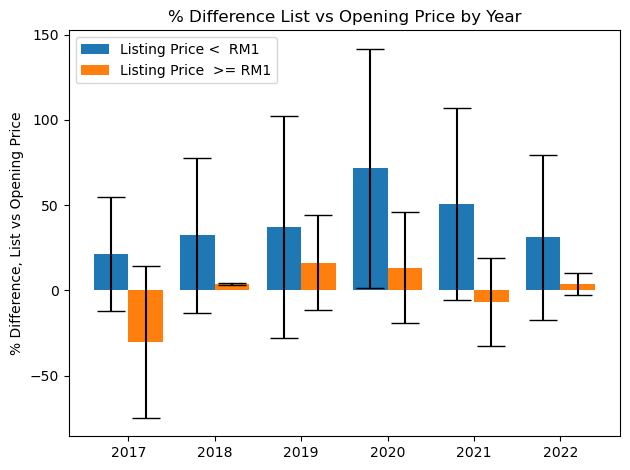

In [12]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('% Difference, List vs Opening Price')
plt.title('% Difference List vs Opening Price by Year')
plt.legend(["Listing Price <  RM1", "Listing Price  >= RM1"])

plt.tight_layout()
plt.show()

We see that there is an increasing trend of higher opening price in 2020 and 2021, as opposed to previous years, and it's only for IPOs priced at less than RM1. Also note the really high standard deviation bars for each year, that suggests that while the average suggests an increasing trend, there is a huge variation within the same year itself.

<b>Also, be aware that while many shares trade higher than their listing price on their IPO day, there are also instances where the shares open lower than their listing prices.</b>

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Highest Price

And now let's look at percentage difference between listing versus highest price on IPO day, per year

In [13]:
count, barheight, barerr = calculate_bardata(years, df, 'LISTVSHIGHEST_PCT')

print("For listing price < RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price >= RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))

For listing price < RM1:
2017(15): mean 40.06, stdev 33.49
2018(32): mean 44.76, stdev 53.42
2019(27): mean 65.76, stdev 108.76
2020(14): mean 95.45, stdev 91.46
2021(40): mean 69.64, stdev 61.7
2022(44): mean 38.8, stdev 51.79

For listing price >= RM1:
2017(9): mean -35.41, stdev 46.8
2018(2): mean -4.73, stdev 15.34
2019(3): mean 16.11, stdev 19.58
2020(3): mean 20.43, stdev 41.43
2021(7): mean 9.58, stdev 36.52
2022(2): mean 8.66, stdev 13.69


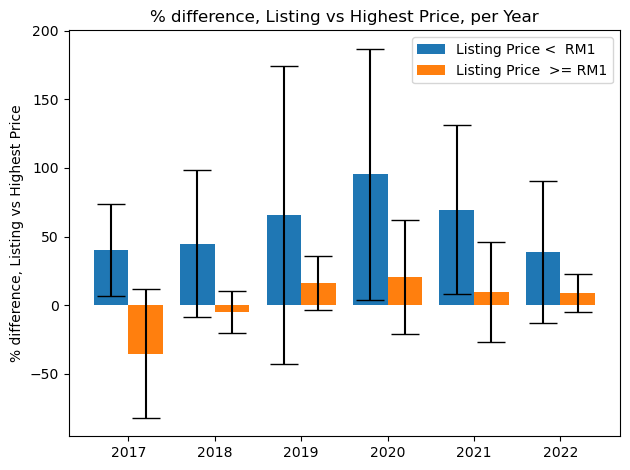

In [14]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('% difference, Listing vs Highest Price')
plt.title('% difference, Listing vs Highest Price, per Year')
plt.legend(["Listing Price <  RM1", "Listing Price  >= RM1"])

plt.tight_layout()
plt.show()

Similar to the above (analysis of % difference of listing vs opening price), we also see that there is an increasing trend of <i>higher highest price during the IPO day</i> in 2020 and 2021, as opposed to previous years, and it is more pronounced for IPOs at less than RM1. Again note the big standard deviation: the average suggests an increasing trend, yet there is a huge variation within the same year itself.

The similar trend for the two previous analysis is not surprising, since % difference of listing versus opening, and % difference of listing versus highest prices, actually correlate strongly (i.e, if the price at open is higher than listing price, it seems that the price will go at least as high/even higher than that, most of the time):

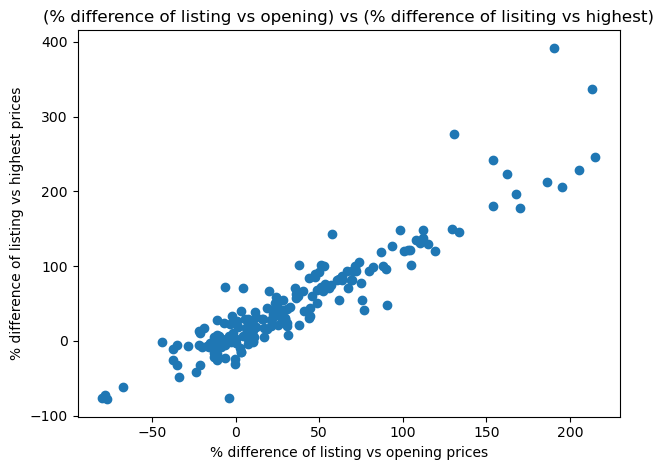

In [15]:
x_label = 'LISTVSOPENING_PCT'
y_label = 'LISTVSHIGHEST_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

ax.set_xlabel('% difference of listing vs opening prices')
ax.set_ylabel('% difference of listing vs highest prices')
    
plt.title('(% difference of listing vs opening) vs (% difference of lisiting vs highest)')
plt.tight_layout()
plt.show()

## Does high public interest during subscription translate into higher activity on IPO day?

Let's now remove analysis by year from the equation, and take the data as aggregate, and ask, if high oversubscription rate correlates into high volume on the counter on IPO day.

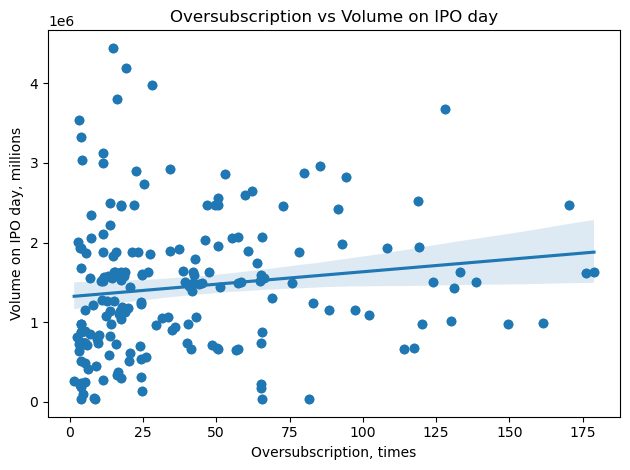

In [16]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'VOLUMEIPODAY'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription, times')
ax.set_ylabel('Volume on IPO day, millions')
    
plt.title('Oversubscription vs Volume on IPO day')
plt.tight_layout()
plt.show()

In [17]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,2))

# Real data:
# R2:  -0.0111
# P-value:  0.92
# stderr:  2882.83

R2:  0.1413
P-value:  0.047
stderr:  1564.02


From the plot and R-square value we can see there is a poor correlation between oversubscription rate and volume on the counter on IPO day.

<i>English speak:</i>
    
<i>R-square value ranges from -1 to 1, where -1 shows strong negative correlation, and 1 shows strong positive correlation. In this case the R-square is only around 0, suggesting there is no correlation.</i>
    
<i>For P-value, the range is from (close to) 0 to 1, where value close to 0 suggests that the value is strongly significant, while 1 suggests that it's probably not very good. What is a good P-value cutoff depends on the case, but for simple test typically statisticians set that P-values need to be maximum 0.05 (or 0.01 if they want to be more strict). Here we have ~0.7, which is rather large.</i>

This suggests that even if a counter was highly oversubscribed, this does not mean that there will be more participants on the counter on IPO day.

## Does high public interest during subscription translate into higher speculative activity on IPO day?
Okay, so it seems that subscription rate doesn't correlate with volume on IPO day. But does subscription rate correlate with higher speculative activity (not volume because we just answered that) on IPO day? i.e, the % difference between listing vs opening, listing vs highest, and maybe also, listing vs closing prices.

Let's see % difference between listing vs opening prices first...

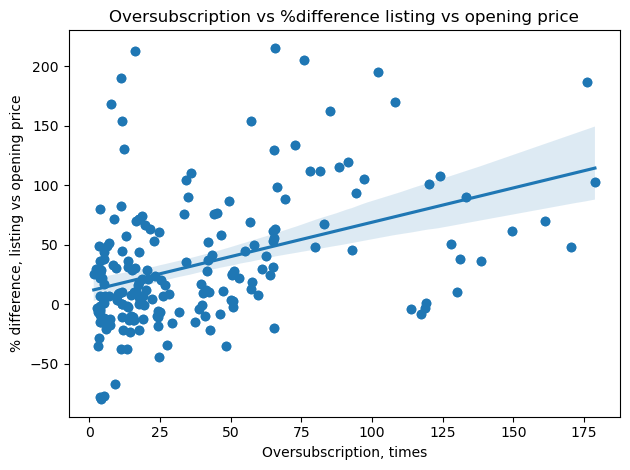

In [18]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription, times')
ax.set_ylabel('% difference, listing vs opening price')

plt.title('Oversubscription vs %difference listing vs opening price')
plt.tight_layout()
plt.show()

In [19]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

# Real data:
# R2:  0.6434
# P-value: 4.1176e-11
# stderr:  0.1208
# equation: y = 0.9192*X + 4.5726

R2:  0.4104
P-value: 1.9107e-09
stderr:  0.0916
equation: y = 0.5772*X + 11.0335


Noice. Looks like there's rather good correlation: the higher public interest in subscribing to the IPO (as measured by the oversubscription rate), the higher likelihood that we'd see higher opening price on IPO day.

<i>We have an R-square value at ~0.6, quite far from 0 for no correlation and halfway to the value 1 (for perfect correlation). Also the P-value is really really small, suggesting the correlation is highly significant.</i>

This tells you that while there is no correlation between oversubscription with volume per se, the ones that participate during IPO day indeed push up the price at market open.

Let's remove points over 40X oversubscription rate, since outliers like those can easily skew the result.

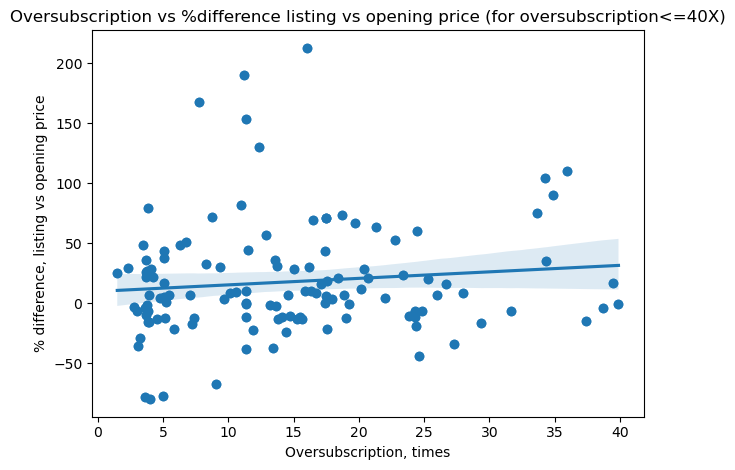

In [20]:
df2 = df[df['TOTALBALLOTINGOSCBED']<40]

x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription, times')
ax.set_ylabel('% difference, listing vs opening price')

plt.title('Oversubscription vs %difference listing vs opening price (for oversubscription<=40X)')
plt.tight_layout()
plt.show()


In [21]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

# Real data:
# R2:  0.4327
# P-value: 7.7431e-04
# stderr:  0.421
# equation: y = 1.4988*X + -1.4282

R2:  0.1107
P-value: 2.1897e-01
stderr:  0.4398
equation: y = 0.5435*X + 9.9333


Yes, the result still holds, albeit with lower R2 value. Noice.

Let's look at oversubscription vs %difference listing-to-highest price. I suspect it will also correlate (since I've already showed that % difference listing-to-opening already correlates with % difference listing-to-highest prices).

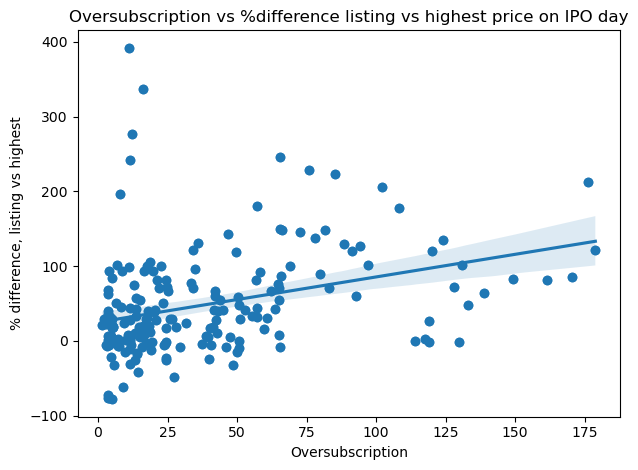

In [22]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs highest')

plt.title('Oversubscription vs %difference listing vs highest price on IPO day')
plt.tight_layout()
plt.show()

In [24]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

# Real data:
# R2:  0.5625
# P-value: 2.5699e-08
# stderr:  0.1446
# equation: y = 0.8906*X + 18.9917

R2:  0.3364
P-value: 1.2635e-06
stderr:  0.1211
equation: y = 0.6054*X + 24.8564


Yup, same. 

The higher public interest in subscribing to the IPO, the higher likelihood that the price will be pushed to a really high level on IPO day.

So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

Again, check for oversubscription less than 40X (it should still hold).

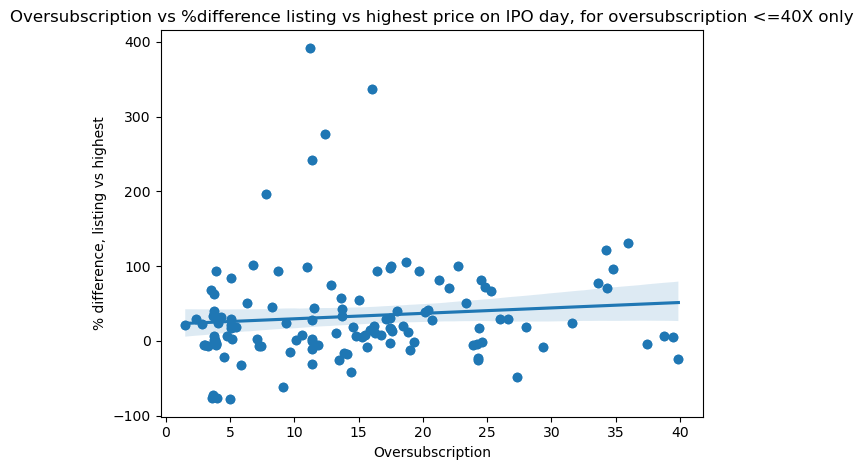

In [25]:
df2 = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs highest')

plt.title('Oversubscription vs %difference listing vs highest price on IPO day, for oversubscription <=40X only')
plt.tight_layout()
plt.show()

In [27]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

# Real data:
# R2:  0.3607
# P-value:  0.0058
# stderr:  0.5496
# equation: y = 1.5762*X + 11.3515

R2:  0.1016
P-value:  0.2596
stderr:  0.6416
equation: y = 0.7267*X + 22.1485


Result holds, again with lower R-square and P-values.

Finally let's look at oversubscription vs %difference listing-to-closing price. Does the stock price tend to settle higher, if it has high oversubscription rate?

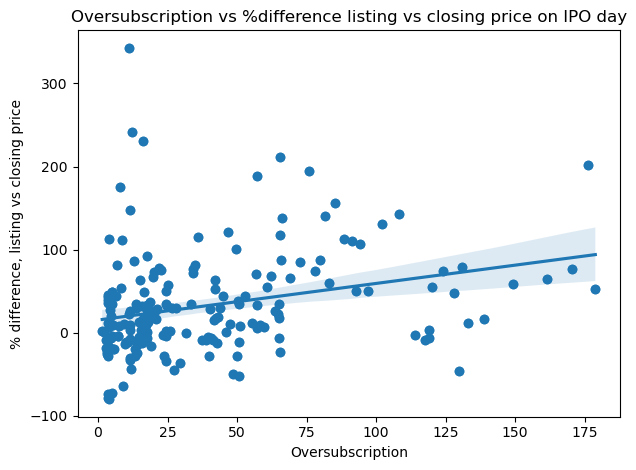

In [28]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs closing price')

plt.title('Oversubscription vs %difference listing vs closing price on IPO day')
plt.tight_layout()
plt.show()

In [30]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

# Real data:
# R2:  0.4436
# P-value: 2.3723e-05
# stderr:  0.126
# equation: y = 0.565*X + 11.0541

R2:  0.2822
P-value: 5.6272e-05
stderr:  0.107
equation: y = 0.4405*X + 15.1162


So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

But you can see that the correlation is weaker now (R2 at 0.4436) vs (R2 at 0.6434 for oversubscription vs % difference listing-vs-opening).

Again, just for completeness, let's verify for oversubscription less than 40X...

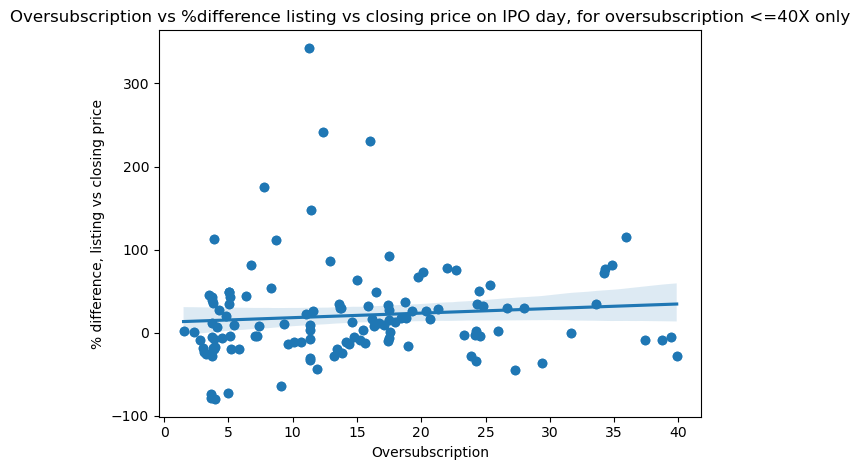

In [31]:
df = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs closing price')

plt.title('Oversubscription vs %difference listing vs closing price on IPO day, for oversubscription <=40X only')
plt.tight_layout()
plt.show()

In [33]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

# Real data:
# R2:  0.3731
# P-value:  0.0043
# stderr:  0.4909
# equation: y = 1.4642*X + -0.8156

R2:  0.09
P-value:  0.3183
stderr:  0.5489
equation: y = 0.55*X + 12.4351


Result holds, albeit with bit worse P-value.

## Summary
Okay, to summarize:
1. There's more interest from the public for IPO in recent years (i.e starting 2020)
    - with a general trend of higher price at market open and during trading day vs previous years.
2. Year 2020 we see the market is flush with liquidity, as there is high volume on an IPO counter.
    - this is in line with higher trading volume in 2020 on the the market overall as already covered elsewhere.
3. Higher oversubscription rate does not translate into higher volume on IPO day
    - seems like, even over the years more and more people are subscribing to IPOs, once they didn't get it, seems like they don't speculate on the counter on the IPO day (?)
4. Yet, higher oversubscription rate correlates with:
    - higher price at market open
    - higher price during trading day
    - higher price at market close

## More Questions
1. As we can collect the data (it's in the Internet, someone just have to do it) on IPO oversubscription for Bumi vs non-Bumi, do these two population groups show different trends over the years?
2. I did not collect data on the market cap or outstanding shares. Is it worth to see if there's any interesting patterns with regards to oversubscription rate, liquidity or % difference from listing price with market cap/#outstanding shares?
3. Also would be interesting to see how fast does trading volume on a recently IPOed counter wanes, when compared to their oversubscription rate or speculative activity on IPO day.

et cetera, et cetera.

Thanks for reading. Hope this worth your time.

<b>Before you go, I have to emphasize this again: This exercise is for entertainment purposes only. Do not trade shares based on this exercise. Trading shares involve capital loss and emotional pain. Please consult your investment advisor before embarking on any financial exercise.
At any trading day there can be wild swings in the market, IPOed shares included.</b>
    
<b>You may be lucky 5 times, but it could take just 1 bad trade to wipe you out. </b>

<b>Do not use the information from this exercise to guide your trading plan.
</b>